In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import  torch
import time
#TODO: remove
%load_ext tensorboard
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

torch.manual_seed(0)

In [ ]:
def polynomial_fun(w, x):
    x = x.view(-1, 1)
    powers_of_x = x**torch.arange(len(w)).view(1, -1)
    y = torch.mm(powers_of_x, w)

    return y.squeeze()

In [ ]:

#implement task script 1

#1) Use polynomial_fun (𝑀 = 2, 𝐰 = [1,2,3]T) to generate a training set and a test set
w = torch.tensor([1, 2, 3], dtype=torch.float32).unsqueeze(1)
x_train = torch.linspace(-20, 20, 20)
x_test = torch.linspace(-20, 20, 10)
y_train = polynomial_fun(w, x_train)
y_test = polynomial_fun(w, x_test)
#observed t values with gauss noise 
t_train = y_train + 0.5 * torch.randn_like(y_train)
t_test = y_test + 0.5 * torch.randn_like(y_test)
fig, ax = plt.subplots()

ax.plot(x_train, y_train, '.')
ax.plot(x_train, t_train, '-')
ax.plot(x_test, y_test, 'o')
ax.plot(x_test, t_test, 'v')

In [9]:

def fit_polynomial_ls(x, t, M):
    x = x.view(-1, 1)
    t = t.view(-1, 1)

    powers_of_x = x**torch.arange(M+1, dtype=torch.float32)

    w = torch.linalg.lstsq(powers_of_x, t).solution

    return w.view(-1)

def fit_polynomial_sgd(x, t, M = 0, lr=1e-2, miniBatchSize=5, print_freq=100, N_epochs=1000):
    #initialise weights to 1

    x = x.view(-1, 1)
    t = t.view(-1, 1)
    pow_of_x = x**torch.arange(M + 1).view(1, -1)
    weights = torch.rand(M + 1, 1, requires_grad=True)

    #print('weights ', model.weight.data)
    #change to sgd
    opt = torch.optim.Adam([weights], lr = lr)
    dataset = TensorDataset(pow_of_x, t)
    loader = DataLoader(dataset, batch_size=miniBatchSize, shuffle=True)
    mse_loss =  torch.nn.MSELoss()
    total_loss = 0.0
    num_batches = 0
    min_loss = torch.inf
    loss_diff_threshold = 1e-2
    losses = []
    grad_norms = []
    
    for epoch in range(N_epochs):
        for batch_x, batch_t in loader:
            #normalize batch x
            #batch_x = (batch_x - batch_x.mean())/batch_x.std()
            #check if this is supposed to be after step
            opt.zero_grad()
            #used wights multiplication wirg batch x to do the prediction
            batch_y = batch_x@weights
            #print('output',  batch_y)
            #mean square loss
            loss = mse_loss(batch_y, batch_t)
            loss.backward() 
            #TODO: for plotting only
            grad_norms.append(weights.grad.norm().item())

            #torch.nn.utils.clip_grad_value_(model.parameters(), 1)
            total_loss += loss.item()
            num_batches += 1
            opt.step()

        avg_loss = total_loss / num_batches
        losses.append(avg_loss)
        
        #doesn't d much 
        if abs(min_loss - loss.item()) < loss_diff_threshold:
            print('Early stopping at epoch {} with loss {}'.format(epoch+1, avg_loss))
            break;
        min_loss = avg_loss
        
        if (epoch + 1) % print_freq == 0:
            print('epoch {} loss {}'.format(epoch+1, avg_loss))
        total_loss = 0.0
        num_batches = 0
        
    #Plotting
    #TODO:remove

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title('Loss per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(grad_norms)
    plt.title('Gradient norm per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient norm')
    plt.show()
                
    return weights.detach()

def descr_stat(powers_of_x, M):
    print("Descriptive Statistics for Polynomial Features")
    for power in range(M ):
        feature = powers_of_x[:, power]
        print(f"Feature x^{power}:")
        print(f"  Mean: {torch.mean(feature).item()}")
        print(f"  Std: {torch.std(feature).item()}")
        print(f"  Min: {torch.min(feature).item()}")
        print(f"  Max: {torch.max(feature).item()}")
        print(f"  25th percentile: {torch.quantile(feature, 0.25).item()}")
        print(f"  Median: {torch.median(feature).item()}")
        print(f"  75th percentile: {torch.quantile(feature, 0.75).item()}")
        print()

In [ ]:
#:TODO remove 
xTrue = torch.arange(4, dtype=torch.float32)
w = torch.tensor([3, 4, 5, 6], dtype=torch.float32).unsqueeze(1)
yTrue = polynomial_fun(w, xTrue)

print(xTrue)
print(yTrue)

a = fit_polynomial_ls(xTrue, yTrue, M=3)
print(a)

In [ ]:

#2) Use fit_polynomial_ls (𝑀𝜖{2,3,4}) to compute the optimum weight 

M = torch.tensor([2,3,4])

#For each 𝑀, compute the predicted target values 𝑦̂ for all 𝑥 in both the training and test sets.
# pred_train = torch.zeros(len(x_train), len(M))
# pred_test = torch.zeros(len(x_test), len(M))
# rmse_train = torch.zeros(len(M))
# rmse_test = torch.zeros(len(M))
diff_obs_train = t_train - y_train
diff_obs_test = t_test - y_test
rmse_obs_train = torch.sqrt(torch.mean(torch.square(y_train - t_train)))
rmse_obs_test = torch.sqrt(torch.mean(torch.square(y_test - t_test)))
print('Training RMSE between the observed training data and the underlying “true” polynomial curve is ', rmse_obs_train.item())
print('Test RMSE between the observed training data and the underlying “true” polynomial curve in training data is ', rmse_obs_test.item())

for i, m in enumerate(M):
    w_hat = fit_polynomial_ls(x_train, t_train, m.item()).unsqueeze(1)
    pred_train = polynomial_fun(w_hat, x_train).squeeze()
    pred_test = polynomial_fun(w_hat, x_test).squeeze()
    
    #rmse
    diff_pred_train = pred_train - y_train
    diff_pred_test = pred_test - y_test
    
    rmse_train = torch.sqrt(torch.mean(torch.square(diff_pred_train)))
    rmse_test = torch.sqrt(torch.mean(torch.square(diff_pred_test)))
    std_dev_train = torch.std(diff_pred_train)
    std_dev_test = torch.std(diff_pred_test)
    
    rmse_train = torch.sqrt(torch.mean(torch.square(diff_pred_train)))
    rmse_test = torch.sqrt(torch.mean(torch.square(diff_pred_test)))
    std_dev_train = torch.std(diff_pred_train)
    std_dev_test = torch.std(diff_pred_test)
    
    print('For polynomial degree', m.item())
    print('Training RMSE between the LS values and the underlying “true” polynomial curve is {:.4f}, and standard deviation is {:.4f}'.format( rmse_train.item(), std_dev_train.item()))
    print('Test RMSE between the LS values and the underlying “true” polynomial curve is {:.4f}, and standard deviation is {:.4f}'.format( rmse_test.item(), std_dev_test.item()))

    #TODO:remove
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.plot(x_train, y_train, ',')
    ax1.plot(x_train, pred_train, '.')
    ax2.plot(x_test, y_test, 'o')
    ax2.plot(x_test, pred_test, 'v')

In [ ]:
# Report, using printed messages, the mean (and standard deviation) in difference a) between
# the observed training data and the underlying “true” polynomial curve; and b) between the
# “LS-predicted” values and the underlying “true” polynomial curve.
#both test and train
diff_obs_train = t_train - y_train
diff_pred_train = pred_train - y_train
diff_obs_test = t_test - y_test
diff_pred_test = pred_test - y_test

sd_obs_train, mean_obs_train = torch.std_mean(diff_obs_train)
sd_pred_train, mean_pred_train = torch.std_mean(diff_pred_train)
sd_obs_test, mean_obs_test = torch.std_mean(diff_obs_test)
sd_pred_test, mean_pred_test = torch.std_mean(diff_pred_test)

print('Training Mean difference between the observed training data and the underlying “true” polynomial curve is ', mean_obs_train.item(), 'and standard diviation is', sd_obs_train.item() )
print('Training Mean difference between “LS-predicted” values and the underlying “true” polynomial curve is {:.3f}, and standard diviation: {:.3f}' .format(mean_pred_train.item(), sd_pred_train.item()) )
print('Test Mean difference between the observed training data and the underlying “true” polynomial curve in training data is ', mean_obs_test.item(), 'and standard diviation is', sd_obs_test.item())
print('Test  Mean difference between “LS-predicted” values and the underlying “true” polynomial curve is {:.3f}, and standard diviation: {:.3f}' .format(mean_pred_test.item(), sd_pred_test.item()) )

epoch 100 loss 5852.8934326171875
epoch 200 loss 153.79797172546387
epoch 300 loss 51.16253042221069
epoch 400 loss 13.379990339279175
epoch 500 loss 3.7369561791419983
Early stopping at epoch 542 with loss 2.6601657271385193


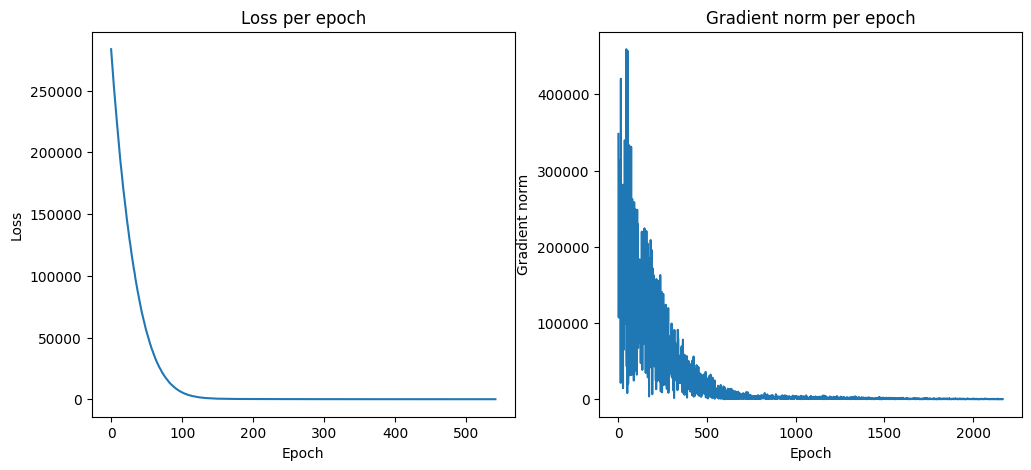

torch.Size([3, 1])
elapsed time for fit_polynomial_sgd: 1.80 seconds
For polynomial degree  2
Training Mean absolute difference between the “SGD-predicted” values and the underlying “true” polynomial curve is 1.475, and standard deviation is 0.784
Test Mean absolute difference between the “SGD-predicted” values and the underlying “true” polynomial curve is 1.475, and standard deviation is 0.784
Training RMSE  between the “SGD-predicted” values and the underlying “true” polynomial curve is 1.661, and standard deviation is 1.301
Test RMSE between the “SGD-predicted” values and the underlying “true” polynomial curve is 1.665, and standard deviation is 1.301
epoch 100 loss 5961.986328125
epoch 200 loss 91.16996669769287
epoch 300 loss 73.81773376464844
epoch 400 loss 60.00783348083496
epoch 500 loss 45.99007701873779
epoch 600 loss 33.87380599975586
epoch 700 loss 21.788715362548828
epoch 800 loss 13.475312352180481
epoch 900 loss 7.881734549999237
Early stopping at epoch 932 with loss 6.3

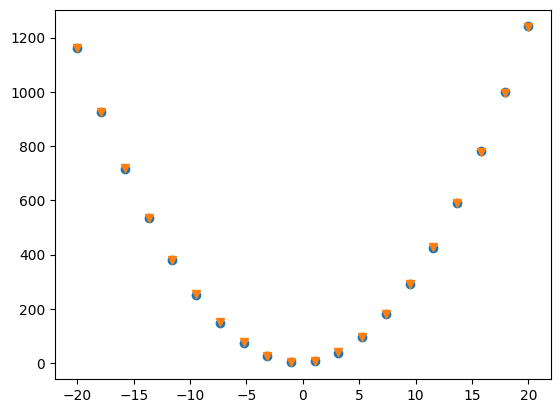

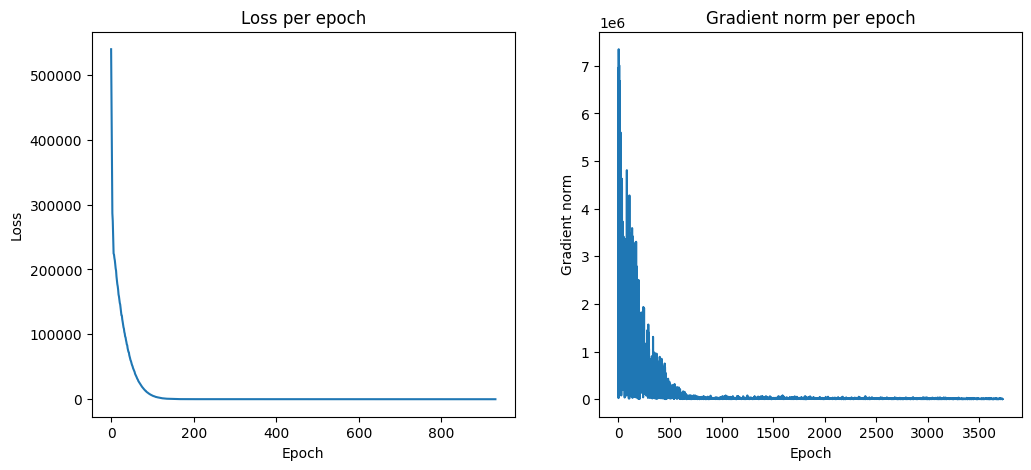

torch.Size([4, 1])
elapsed time for fit_polynomial_sgd: 3.68 seconds
For polynomial degree  3
Training Mean absolute difference between the “SGD-predicted” values and the underlying “true” polynomial curve is 2.111, and standard deviation is 1.379
Test Mean absolute difference between the “SGD-predicted” values and the underlying “true” polynomial curve is 2.111, and standard deviation is 1.379
Training RMSE  between the “SGD-predicted” values and the underlying “true” polynomial curve is 2.502, and standard deviation is 2.390
Test RMSE between the “SGD-predicted” values and the underlying “true” polynomial curve is 2.701, and standard deviation is 2.390
epoch 100 loss 41064.683837890625
epoch 200 loss 28905.42529296875
epoch 300 loss 27790.05029296875
epoch 400 loss 27353.0556640625
epoch 500 loss 26864.0419921875
epoch 600 loss 26177.99951171875
epoch 700 loss 25408.025634765625
epoch 800 loss 24436.157470703125
epoch 900 loss 23325.228759765625
epoch 1000 loss 22128.076080322266


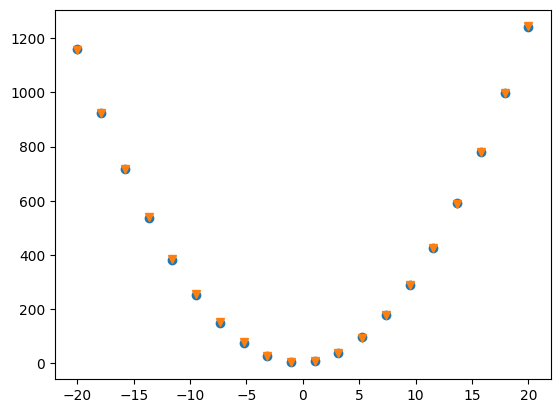

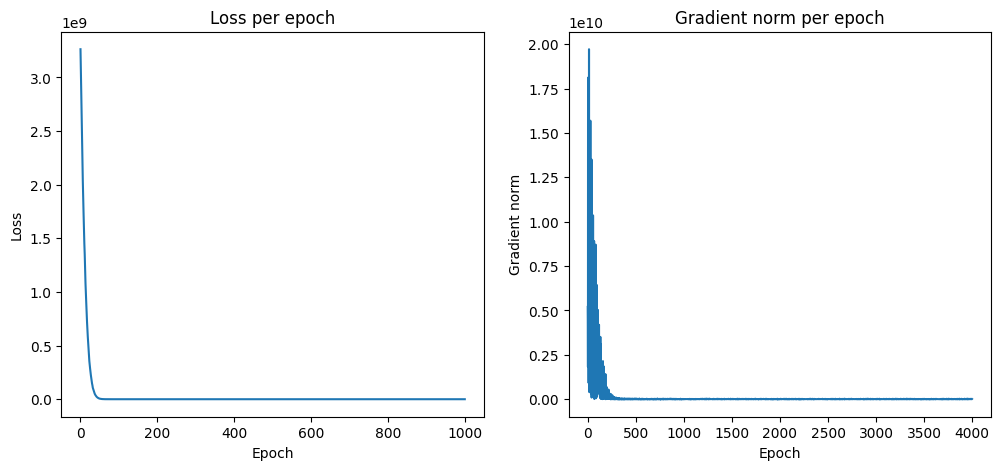

torch.Size([5, 1])
elapsed time for fit_polynomial_sgd: 3.88 seconds
For polynomial degree  4
Training Mean absolute difference between the “SGD-predicted” values and the underlying “true” polynomial curve is 126.150, and standard deviation is 79.666
Test Mean absolute difference between the “SGD-predicted” values and the underlying “true” polynomial curve is 126.150, and standard deviation is 79.666
Training RMSE  between the “SGD-predicted” values and the underlying “true” polynomial curve is 148.132, and standard deviation is 118.752
Test RMSE between the “SGD-predicted” values and the underlying “true” polynomial curve is 156.178, and standard deviation is 118.752


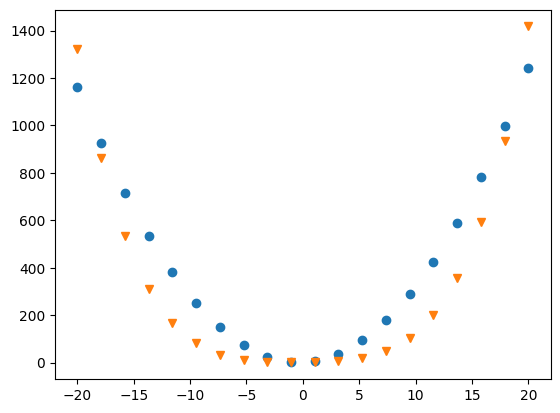

In [10]:
#Use fit_polynomial_sgd (𝑀𝜖{2,3,4}) to optimise the weight vector 𝐰̂ using the training set.
# For each 𝑀, compute the predicted target values 𝑦̂ for all 𝑥 in both the training and test sets.
#  Report, using printed messages, the mean (and standard deviation) in difference between the
# “SGD-predicted” values and the underlying “true” polynomial curve
# Normalize x_train and x_test

for i, m in enumerate(M):
    t0 = time.time()
    w_hat_opimized = fit_polynomial_sgd(x_train, t_train, m.item())
    print(w_hat_opimized.shape)
    t1 = time.time()
    print("elapsed time for fit_polynomial_sgd: %.2f seconds" % (t1-t0))
    #training
    pred_train_opt = polynomial_fun(w_hat_opimized, x_train).squeeze()
    
    #test
    pred_test_opt = polynomial_fun(w_hat_opimized, x_test).squeeze()
    
    #TODO: remove all plots
    fig, ax = plt.subplots()
    ax.plot(x_train, t_train, 'o')
    ax.plot(x_train, pred_train_opt, 'v')
    
    #polynomial degree
    print('For polynomial degree ', m.item())
    #mean difference 
    std_difference_tr, mean_difference_tr = torch.std_mean(torch.abs(pred_train_opt - y_train))
    std_difference_te, mean_difference_te = torch.std_mean(torch.abs(pred_train_opt - y_train))
    print('Training Mean absolute difference between the “SGD-predicted” values and the underlying “true” polynomial curve is {:.3f}, and standard deviation is {:.3f}'.format( mean_difference_tr.item(), std_difference_tr.item()))
    print('Test Mean absolute difference between the “SGD-predicted” values and the underlying “true” polynomial curve is {:.3f}, and standard deviation is {:.3f}'.format( mean_difference_te.item(), std_difference_te.item()))
    
    #rmse
    diff_pred_train_opt = pred_train_opt - y_train
    diff_pred_test_opt = pred_test_opt - y_test
    rmse_train_opt= torch.sqrt(torch.mean(torch.square(diff_pred_train_opt)))
    rmse_test_opt= torch.sqrt(torch.mean(torch.square(diff_pred_test_opt)))
    std_dev_train_opt = torch.std(diff_pred_train_opt)
    std_dev_test_opt = torch.std(diff_pred_train_opt)
    print('Training RMSE  between the “SGD-predicted” values and the underlying “true” polynomial curve is {:.3f}, and standard deviation is {:.3f}'.format( rmse_train_opt.item(), std_dev_train_opt.item()))
    print('Test RMSE between the “SGD-predicted” values and the underlying “true” polynomial curve is {:.3f}, and standard deviation is {:.3f}'.format( rmse_test_opt.item(), std_dev_test_opt.item()))

#0-15 for M 2, 3
#15-30 M 4
#loss approaching 0

#preload polynomial 
#learn what the best M is, do polynomial up tp 10 th degree,
#assign each degree learnable probability of thebing ignored, each probability of ebing dropped out 